# Mobile Games A/B Testing - Cookie Cats 
## Which version is better?
data: https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats <br>
### The main purpose of this project is to compare users' retention rate after 7 days of game installing between two gate versions. 

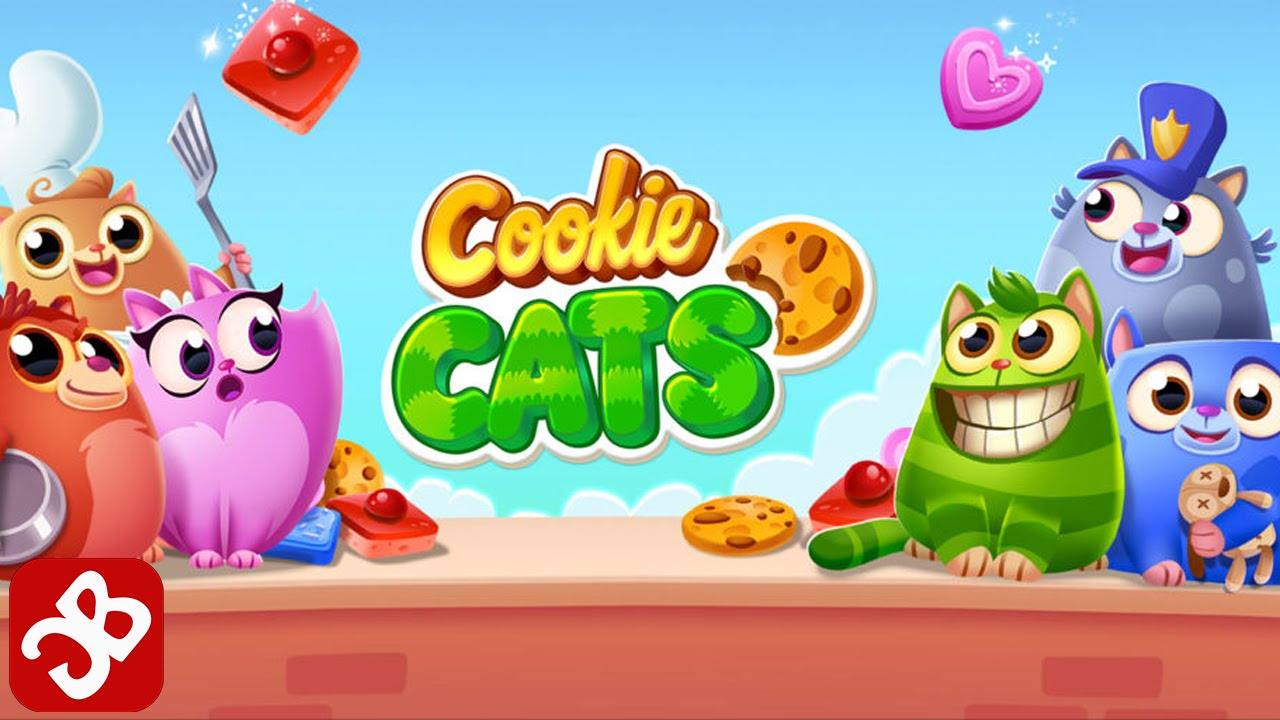

In [120]:
from IPython.display import Image
Image('https://i.ytimg.com/vi/LkvnfULq8yQ/maxresdefault.jpg')

## Outline: <br>

1. [Import libraries](#Import_libraries) 
2. [EDA](#EDA)
3. [A/B test using Chi-Square](#chi-2)<br>
    (1) [Hypothesis](#chi_h)<br>
    (2) [Contingency Table](#contingency_table)<br>
    (3) [Chi-square Test](#chi_test)<br>
    (4) [Conclusion](#chi_con)<br>
4. [Bayesian A/B Testing](#bayes)<br>
    (1) [Hypothesis](#bay_h)<br>
    (2) [Data overview](#data)<br>
    (3) [Set prior for Beta distribution](#beta_prior)<br>
    (4) [Data Visualization: Data Distribution](#dis_vis)<br>
    (5) [Result and Conclusion](#beta_con)
5. [Conclusion](#conclusion)

### 1. Import libraries<a id='Import_libraries'>

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
from scipy.stats import beta
from scipy.stats import chi2_contingency, chi2

### 2. EDA<a id = EDA>

__Read data and data overview__

In [3]:
df = pd.read_csv('cookie_cats.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


__Content__<br>
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:<br>
<br>
userid: A unique number that identifies each player.<br>
version: Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).<br>
sumgamerounds: the number of game rounds played by the player during the first 14 days after install.<br>
retention1: Did the player come back and play 1 day after installing?<br>
retention_7: Did the player come back and play 7 days after installing?<br>
<br>
When a player installed the game, he or she was randomly assigned to either.<br>

In [18]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [63]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [25]:
# Data is not duplicated
df.duplicated().sum()

0

In [7]:
# All values in "userid” is unique

for i in df.userid.value_counts():
    if i !=1 :
        print(i)

#### sample size in each version

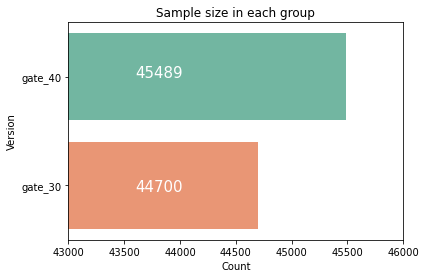

,version
gate_40,45489
gate_30,44700


In [55]:
# sample size in each version
data = pd.DataFrame(df.version.value_counts())
sns.barplot(data = data, x = 'version', y = data.index, palette = 'Set2')
plt.xlim(43000, 46000)
plt.title('Sample size in each group')
plt.xlabel('Count')
plt.ylabel('Version')

gate30 = data.loc['gate_30', 'version']
gate40 = data.loc['gate_40', 'version']

plt.annotate(f'{gate30}', (43600,1.05), fontsize = 15, color = '#ffffff')
plt.annotate(f'{gate40}', (43600,0), fontsize = 15, color = '#ffffff')

plt.show()
data

In [35]:
data.loc['gate_40', 'version']

45489

__Data visualization:__ Retention rate in gate30 and gate40

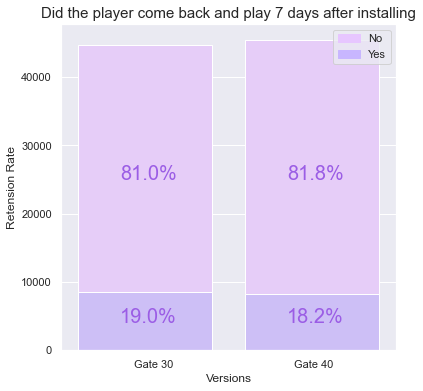

retention_1,False,True
version,,
gate_30,0.551812,0.448188
gate_40,0.557717,0.442283


In [56]:
import matplotlib.patches as mpatches

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(6,6))

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = df.groupby('version')['retention_7'].count().reset_index()

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="version",  y='retention_7', data=total, color='#e7c6ff')

# bottom bar ->  take only smoker=Yes values from the data
smoker = df.groupby('version')['retention_7'].sum().reset_index()


# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="version", y="retention_7", data=smoker, estimator=sum, ci=None,  color='#c8b6ff')

# add legend
top_bar = mpatches.Patch(color='#e7c6ff', label='No')
bottom_bar = mpatches.Patch(color='#c8b6ff', label='Yes')
plt.legend(handles=[top_bar, bottom_bar])

# label
pct_30 = round(df.loc[df.version == 'gate_30']['retention_7'].mean()*100, 1)
pct_40 = round(df.loc[df.version == 'gate_40']['retention_7'].mean()*100, 1)

plt.annotate(f'{pct_30}%', (0.8-1+0.05,4000), fontsize = 20, color = '#9b5de5')
plt.annotate(f'{pct_40}%', (1.8-1+0.05,4000), fontsize = 20, color = '#9b5de5')

plt.annotate(f'{100-pct_30}%', (0.8-1+0.05,25000), fontsize = 20, color = '#9b5de5')
plt.annotate(f'{100-pct_40}%', (1.8-1+0.05,25000), fontsize = 20, color = '#9b5de5')

plt.xlabel('Versions', fontsize = 12)
plt.ylabel('Retension Rate', fontsize = 12)
plt.title('Did the player come back and play 7 days after installing', fontsize = 15)
plt.xticks(ticks = [0.05, 1.01], labels = ['Gate 30', 'Gate 40'])

# show the graph
plt.show()

# show the table
df.groupby('version').retention_1.value_counts(normalize = True).unstack()

__Retention rate in gate30 and gate40__

In [122]:
df.groupby('version').retention_7.value_counts(normalize = True).unstack()

retention_7,False,True
version,,
gate_30,0.809799,0.190201
gate_40,0.818000,0.182000


__Data visualization:__ The number of game rounds played by the player during the first 14 days after install

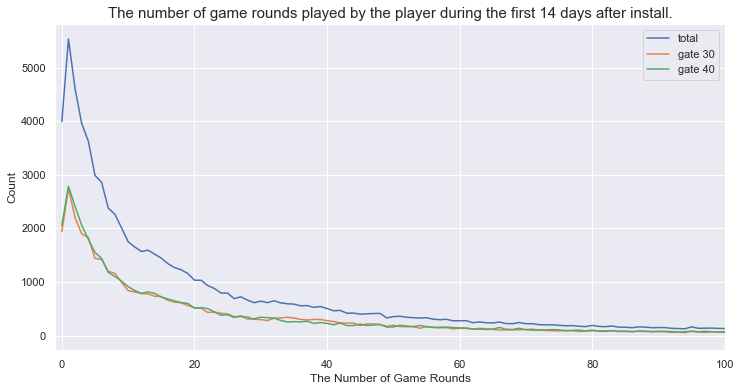

The distribution of number of game rounds looks similar between gate30 and gate40


In [60]:
# data
count_times = df.groupby('sum_gamerounds').version.count().reset_index()

plt.figure( figsize = (12,6))

# left figure
count_times = df.groupby('sum_gamerounds').version.count().reset_index()
sns.lineplot(data = count_times, x = 'sum_gamerounds', y = 'version', label = 'total')

# righr figure
count_times_30 = df.loc[df.version == 'gate_30'].groupby('sum_gamerounds').version.count().reset_index()
count_times_40 = df.loc[df.version == 'gate_40'].groupby('sum_gamerounds').version.count().reset_index()

sns.lineplot(data = count_times_30, label = 'gate 30', x = 'sum_gamerounds', y = 'version')
sns.lineplot(data = count_times_40, label = 'gate 40', x = 'sum_gamerounds', y = 'version')

plt.legend()
plt.xlim(-1,100)
plt.xlim(-1,100)

plt.title('')
plt.xlabel('The Number of Game Rounds')
plt.ylabel('Count')
plt.title('The number of game rounds played by the player during the first 14 days after install.', fontsize = 15)
print('')
plt.show()
print('The distribution of number of game rounds looks similar between gate30 and gate40')

### 2. A/B test: Chi-square<a id = chi-2>

#### Using Chi-square to compare which version has a better performance in retention rate

#### (1) Hypothesis<a id = chi_h>
- H0: There is no difference of retension_7 between version gate_30 and gate_40
- H1: There is a difference of retention_7 between version gate_30 and gate_40
- alpha = 0.05


#### (2) Contingency table <a id = contingency_table>

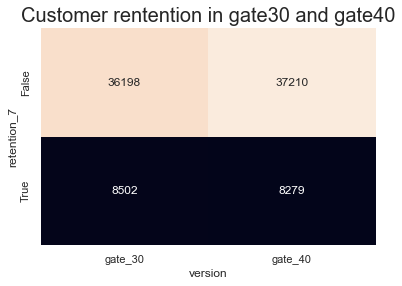

version,gate_30,gate_40,Total
retention_7,,,
False,36198.0,37210.0,73408.0
True,8502.0,8279.0,16781.0
total,44700.0,45489.0,90189.0


In [61]:
# table
v = df.groupby('version').retention_7.value_counts().unstack()#.sum(axis = 1)
v['total'] = df.groupby('version').retention_7.value_counts().unstack().sum(axis = 1)
v.loc['Total',:] = df.groupby('version').retention_7.value_counts().unstack().sum()
v.loc['Total', 'total'] = v.total.sum()
v = v.T

# Visualization
observed_value = [[36198, 8502],[37210,8279]]
sns.heatmap(v.iloc[0:2, 0:2], annot=True, fmt='g', cbar=False)
plt.title('Customer rentention in gate30 and gate40', fontsize = 20)
plt.show()

v

Text(30.5, 0.5, 'Rentention on day 7')

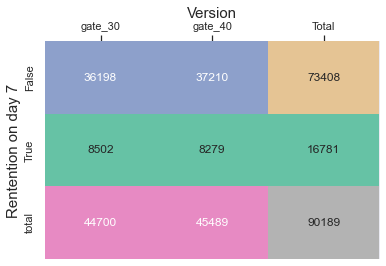

In [72]:
ax = sns.heatmap(v, annot=True, fmt='g', cbar=False, cmap = 'Set2')
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_xlabel('Version', fontsize = '15')
ax.set_ylabel('Rentention on day 7', fontsize = '15')

#### (3) Chi-square test<a id = chi_test>

In [7]:
chi2_static, p_value, dof, expected_value = chi2_contingency(observed_value , correction=False)
print(chi2_static, p_value)

10.013167328688969 0.0015542499756142805


#### (4) Conclusion: Sanity Check and result report <a id = chi_con>

In [128]:
# Sanity Check
a_30 = v.loc[True, 'gate_30']/v.loc['total', 'gate_30']
b_40 = v.loc[True, 'gate_40']/v.loc['total', 'gate_40']

# odds ratio
odds_30_true = v.loc[True, 'gate_30']/v.loc[False, 'gate_30']
odds_40_true = v.loc[True, 'gate_40']/v.loc[False, 'gate_40']
odds_ratio = odds_30_true/odds_40_true

print(f"There was a significant association between version (Gate30 and Gate40) and retention rate.")
print(f"X2(1) = {round(chi2_static,1)}, p < 0.001.")
print(f"Based on the odds ratio, the odds of retention rate after 7 days is {round(odds_ratio, 1)} times higher in gate30 than gate40.")
print(f"Retention rate is {round(a_30, 3)} in gate30  and {round(b_40,3)} in gate40")
print('Gate30 has a better retention rate than gate40')

There was a significant association between version (Gate30 and Gate40) and retension rate.
X2(1) = 10.0, p < 0.001.
Based on the odds ratio, the odds of retention rate after 7 days is 1.1 times higher in gate30 than gate40.
Retentention rate is 0.19 in gate30  and 0.182 in gate40
Gate30 has a better retention rate than gate40


### 3. Bayesian A/B Test<a id= 'bayes'>

#### Using Chi-square to compare which version has a better performance in retention rate

#### (1) Hypothesis<a id = bay_h>
- H0: There is no difference of retension_7 between version gate_30 and gate_40
- H1: There is a difference of retention_7 between version gate_30 and gate_40
- alpha = 0.05

#### (2) Data overview<a id = data>

In [129]:
gate30_true = df.loc[df.version == 'gate_30'].retention_7.sum()
gate30_false = df.loc[df.version == 'gate_30'].retention_7.count()-gate30_true

gate40_true = df.loc[df.version == 'gate_40'].retention_7.sum()
gate40_false = df.loc[df.version == 'gate_40'].retention_7.count()-gate40_true

print('gate30 success: ', gate30_true)
print('gate30 false: ', gate30_false)
print("gate30 total observations:", len(df.loc[df.version == 'gate_30']))
print('')
print('gate40 success: ', gate40_true)
print('gate40 false: ', gate40_false)
print("gate40 total observations:", len(df.loc[df.version == 'gate_40']))
v


gate30 success:  8502
gate30 false:  36198
gate30 total observations: 44700

gate40 success:  8279
gate40 false:  37210
gate40 total observations: 45489


version,gate_30,gate_40,Total
retention_7,,,
False,36198.0,37210.0,73408.0
True,8502.0,8279.0,16781.0
total,44700.0,45489.0,90189.0


#### (3)  Set prior for Beta distribution<a id = beta_prior>

In [73]:
from scipy import stats
import numpy as np
 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
 
@interact
def beta_plot(a=5, b=10):
     
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
 
    beta = lambda x, a, b: stats.beta.pdf(x, a, b)
    axs[0].plot(np.linspace(0, 1, 100), beta(np.linspace(0, 1, 100), a, b))
    axs[0].set_xlabel(f'f({a},{b})')
    axs[0].set_ylabel('density')
    axs[1].plot(np.linspace(0, 1, 100), beta(np.linspace(0, 1, 100), 1.005, 1.005))
    axs[1].set_xlabel('f(1,1)')
    axs[1].set_ylabel('density')
    return

interactive(children=(IntSlider(value=5, description='a', max=15, min=-5), IntSlider(value=10, description='b'…

In [137]:
prior_alpha = 4
prior_beta = 13

# simulating the posterior distribution for gate30
control_post = np.random.beta(prior_alpha + gate30_true, prior_beta + gate30_false, 10000)
#control_post.mean()

# simulating the posterior distribution for gate40
test_post = np.random.beta(prior_alpha + gate40_true, prior_beta + gate40_false, 10000)
test_post.mean()

# simulating the prior distribution 
control_post1 = np.random.beta(prior_alpha, prior_beta , 10000)

print(f"The mean of simulating  prior is {round(control_post1.mean(),3)}")
print(f"The mean of simulating posterior for gate30 is {round(control_post.mean(),3)}")
print(f"The mean of simulating posterior for gate40 is {round(test_post.mean(),3)}")

The mean of simulating  prior is 0.236
The mean of simulating posterior for gate30 is 0.19
The mean of simulating posterior for gate40 is 0.182


#### (4) Data visualization: Distributions <a id = dis_vis>

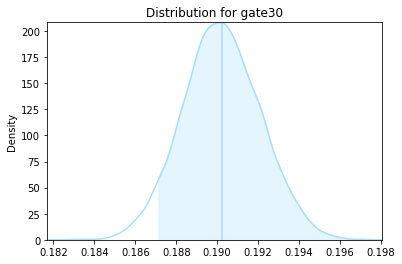

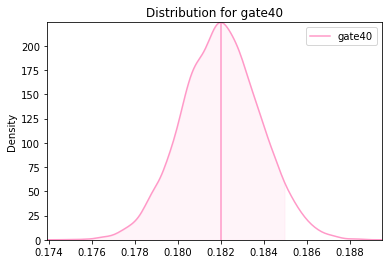

In [140]:
# calculate mean, standard diviation and variance 
res_mean_a, res_var_a, res_std_a = stats.bayes_mvs(control_post, alpha=0.95)
res_mean_b, res_var_b, res_std_b = stats.bayes_mvs(test_post, alpha=0.95)

ax = sns.kdeplot(control_post, label = 'gate30', color = '#a9def9')  # plot distribution for gate30 (A)
plt.axvline(x = res_mean_a.statistic, color = '#a9def9')

l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
x_1 = []
y_1 = []
for i, j in zip(x1, y1):
    if i > res_mean_a.statistic-res_std_a.statistic*1.645:
        x_1.append(i)
        y_1.append(j)
ax.fill_between(x_1, y_1, color = '#a9def9', alpha=0.3)
ax.margins(x=0, y=0)
ax.set_title('Distribution for gate30')
plt.show()
# visulaization
ax2 = sns.kdeplot(test_post, label = 'gate40', color = '#ff99c8')   # plot distribution for gate40 (B)
plt.axvline(x = res_mean_b.statistic, color = '#ff99c8')
l2 = ax2.lines[0]
x2 = l2.get_xydata()[:, 0]
y2 = l2.get_xydata()[:, 1]
x_2 = []
y_2 = []
for i, j in zip(x2, y2):
    if i < res_mean_b.statistic+res_std_b.statistic*1.645:
        x_2.append(i)
        y_2.append(j)
ax2.fill_between(x_2, y_2, color = '#ff99c8', alpha=0.1)
ax2.margins(x=0, y=0)
ax2.set_title('Distribution for gate40')

plt.legend()
plt.show()

#### (5) Results and conclusion <a id = beta_con>

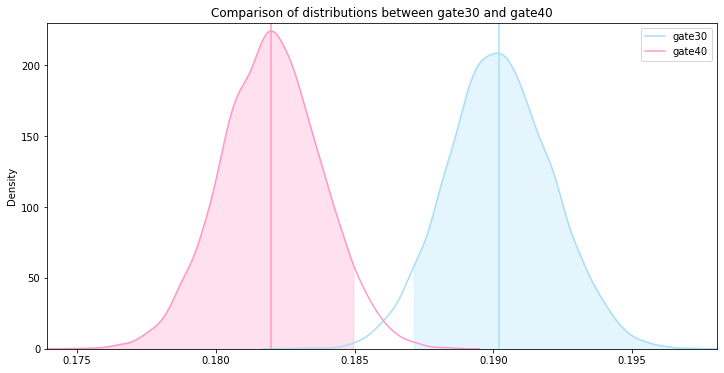

The probability of gate30 is better than gate40 is 0.95%
We are almost 100% sure that the retantion rate of gate30 is 0.96 times better than gate40.
The retention rate of gate30 is 0.19021439673020651 and gate40 is 0.18199302474738346
Therefore gate30 will have a better retention rate compare to gate40.


In [189]:
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.integrate import simps
import numpy as np

plt.figure(figsize = (12,6))
#sns.kdeplot(control_post1, label = 'prior')       # plot distribution for prior
ax = sns.kdeplot(control_post, label = 'gate30', color = '#a9def9')  # plot distribution for gate30 (A)
plt.axvline(x = res_mean_a.statistic, color = '#a9def9')

l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
x_1 = []
y_1 = []
for i, j in zip(x1, y1):
    if i > res_mean_a.statistic-res_std_a.statistic*1.645:
        x_1.append(i)
        y_1.append(j)
ax.fill_between(x_1, y_1, color = '#a9def9', alpha=0.3)
ax.margins(x=0, y=0)


ax2 = sns.kdeplot(test_post, label = 'gate40', color = '#ff99c8')   # plot distribution for gate40 (B)
plt.axvline(x = res_mean_b.statistic, color = '#ff99c8')

ax2.fill_between(x_2, y_2, color = '#ff99c8', alpha=0.3)
ax2.margins(x=0, y=0)

plt.title('Comparison of distributions between gate30 and gate40')
plt.ylim(0,230)

plt.legend()
plt.show()


diff = test_post - control_post
diff
#print(f"The probability of gate40 is better than gate30 is {((diff > 0).mean())*100}%")
print(f"The probability of gate30 is better than gate40 is {1-((diff > 0).mean())*100}%")
print(f'We are almost 100% sure that the retention rate of gate30 is {round(res_mean_b.statistic/res_mean_a.statistic, 2) } times better than gate40.')
print(f'The retention rate of gate30 is {res_mean_a.statistic} and gate40 is {res_mean_b.statistic}')
print('Therefore gate30 will have a better retention rate compare to gate40.')

#### Data visualization: the difference between gate30 and gate40 

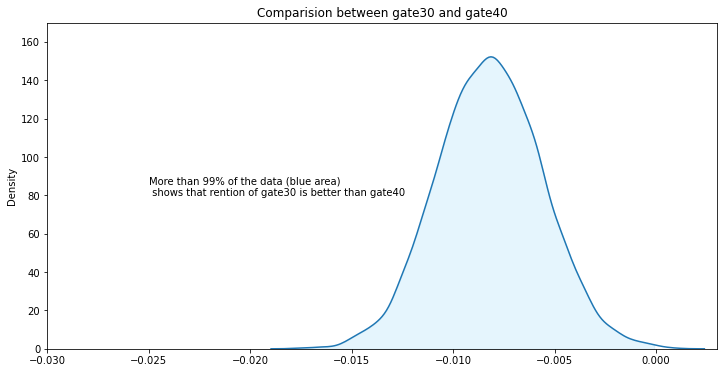

In [182]:
plt.figure(figsize=(12,6))
ax = sns.kdeplot(diff)
#plt.axvline(x = 0, color = 'orange')
#plt.axvline(diff.mean())
#plot.lines(0, color = 'red')
plt.xlim(-0.03, 0.003)
plt.ylim(0,170)

l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
x_1 = []
y_1 = []
for i, j in zip(x1, y1):
    if i < 0:
        x_1.append(i)
        y_1.append(j)
ax.fill_between(x_1, y_1, color = '#a9def9', alpha=0.3)
ax.margins(x=0, y=0)
plt.title('Comparision between gate30 and gate40')
plt.annotate(text = 'More than 99% of the data (blue area) \n shows that rention of gate30 is better than gate40', xy = (-0.025, 80))
plt.show()

### (5) Conclusion <a id = conclusion>
- The results from Chi-square and Bayesian tests show that gate30 has a better retention rate than gate40 after 7 days.